## Optimierungsmodelle in der Praxis (WS 20/21) | Abgabeblatt 2
#### Von: Kai Firschau, David Taubner, Davis Tonon

-----

## Python-Modul

In [93]:
# Import Python modules

import pandas as pd
import numpy as np
from gurobipy import GRB, Model, quicksum
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns

# Initialize class MathFireflies

class MathFireflies:
    """ Math Fireflies Game.
    
    This class represents instances of the board game Math Fireflies for
    arbitrary scaled game boards and colors, provides functions to solve
    the game for given start values, and to plot start values and solutions.
    
    Parameters
    ----------
    n_rows : int
        The number of rows of the game board
    n_columns: int
        The number of columns of the game board
    start_values: dict of str to int
        The start values for the game instance, as a dictionary mapping colors to 
        numbers from range(rows*columns), containing no duplicates.
        
        Note: The color strings have to be valid matplotlib-inputs, see:
        https://matplotlib.org/3.1.0/gallery/color/named_colors.html
        
        Example:
        {
            'orange' : 22,
            'purple' : 43,
            'red' : 27,
            'green' : 12,
            'black' : 14
        }
    """
    
    
    
    def __init__(self, n_rows, n_columns, start_values):
        
        # Store the passed game board dimensions, i.e. the numbers of rows and columns
        self.n_rows = n_rows
        self.n_columns = n_columns
        
        # Create a grid graph for further computations from the given game board dimensions  
        self.graph = nx.grid_2d_graph(n_rows, n_columns)
        
        # Use the graph to compute the nodes and the neighbors for each node
        self.nodes = [node for node in self.graph.nodes]
        self.neighbors = {}
        for n in self.nodes:
            self.neighbors[n] = [x for x in self.graph.neighbors(n)]
        
        # Save the initial start values and check for plausibility
        if len(start_values.keys()) != len(set(start_values.keys())):
            raise Error("start_values contains at least one color multiple times.")
        if len(start_values.values()) != len(set(start_values.values())):
            raise Exception("start_values contains at least one number multiple times.")
        
        # Store the passed colors and the number of colors
        self.colors = list(start_values.keys())
        self.n_colors = len(self.colors)
        
        # Compute a color-mapping to enable transforming numeric color values into color strings and vice versa
        self.color_dict = {color_index : color_string for color_index, color_string in zip(range(self.n_colors), self.colors)}
        
        # Transform the initial start values into a dict mapping the graph coordinates to numeric color values.
        # Explanation: the scalar position from the passed start_values equals the position of the corresponding
        # tuple/coordinate position within graph, and the position of the passed color string in the color array its 
        # numeric color value. Example: {"red" : 42} ==> {(8,2) : 1}
        
        self.start_values = {self.nodes[start_values[c]] : self.colors.index(c) 
                             for c in start_values}
        
        # Compute the number of stones per color
        if (self.n_rows*self.n_columns) % self.n_colors != 0:
            raise Exception("""Please choose the input such that the number of stones can be distributed
                               evenly across the number of colors.""")
        self.n_stones_per_color = int((self.n_rows*self.n_columns) / self.n_colors)
        
        # Initialize further variables to store states after the optimization process
        self.model = None
        self.is_solved = False
        self.variables = None
        self.result = None
    
    
    
    def solve(self, prevent_rectangles=True):
        """ Solve the Math Fireflies optimization problem for the current instance's start values.
        
        Parameters
        ----------
        prevent_rectangels : {boolean}, default=True
            Specifies whether to prevent the creation of rectangles or not.
        
        Returns
        ----------
        model : {gurobipy.Model} 
            Solved binary linear optimization model.
        result : {dict} 
            Solution of the Math Fireflies game for given start_values
            Shape: {(row-index, column-index) : color}
            Len: n_rows * n_columns
        """

        ##################### INDEX SETS #####################

        # Row index
        I = range(self.n_rows)

        # Column index
        J = range(self.n_columns)

        # Color index
        F = range(self.n_colors)

        # Stones per color index
        N = range(self.n_stones_per_color)
        
    
        ################ MODEL INITIALIZATION ################

        m = Model('Math Fireflies')

        
        ################# DECISION VARIABLES #################
        
        # Add one decision variable for every possible stone of every color on every possible position 
        x = m.addVars(I, J, F, N, vtype=GRB.BINARY)
        
        #################### CONSTRAINTS #####################

        ##### C1: Each field can be only occupied by one stone at a time

        c1 = m.addConstrs(
                quicksum(x[i,j,f,n] for f in F for n in N) == 1
                for i in I for j in J
             )

        ##### C2: For each color, there are exactly n_stones_per_color stones

        c2 = m.addConstrs(
                quicksum(x[i,j,f,n] for i in I for j in J for n in N) == self.n_stones_per_color
                for f in F
             )

        ##### C3: Each stone is used exactly once at a time

        c3 = m.addConstrs(
                quicksum(x[i,j,f,n] for i in I for j in J) == 1
                for f in F for n in N
             )

        ##### C4: Each stone must have at least one stone of the same color in the direct neighborhood

        # Plausibility check: verify if the graph's node coordinates match the decision variable coordinates, i.e.
        # if the decision variables have been initialized correctly
        if set(self.graph.nodes) == set([(t[0], t[1]) for t in  list(x.keys())]):

            c4 = m.addConstrs(
                    x[i,j,f,n] <= quicksum(x[r,c,f,n+1] for (r,c) in self.neighbors[(i,j)])
                    for i in I for j in J for f in F for n in range(9)
                 )

        else:
            raise Exception('Indices (i,j) of the decision variables x[i,j,f,n] do not match the specified graph.')
        
        ##### C5: Start value constraints
        
        c5 = m.addConstrs(
                # One of the n stones of color f has to be set on position (i,j)
                quicksum(x[i,j,f,n] for n in N) == 1
                for ((i,j),f) in self.start_values.items()
             )
        
        ##### C6: No rectangles or squares of the same color within the game board are allowed (if specified)
        
        if prevent_rectangles == True:
            
            c6 = m.addConstrs(
                    quicksum(x[r,c,f,k] for (r,c) in self.neighbors[(i,j)] for k in range(n+3,self.n_stones_per_color)) <= (1 - x[i,j,f,n]) * len(self.neighbors[(i,j)])
                    for i in I for j in J for f in F for n in N
                 )
        
        #################### OPTIMIZATION ####################
        
        m.update()
        
        m.optimize()
        
        if m.Status == 2:
            self.is_solved = True
        else:
            self.is_solved = True
            print("Model is infeasible.")
            return
        
        # Store the decision variables and the final model 
        self.variables = list(x)
        self.model = m
        
        # Get the decision variable indices that are used in the solution, i.e. where x[i,j,f,n]==1, and save them
        # as a dict of shape {(row-index, column-index) : color}
        self.result = {self.variables[i][:2] : self.variables[i][2] 
                       for var, i in zip(self.model.X, range(len(self.model.X))) if var==1.0}
        
        return (self.model, self.result)
    
    
    
    def visualize_result(self):
        """ Plot the solved Math Fireflies game board as a two-dimensional grid graph. 
        """
        
        if self.is_solved == False:
            print("Model is not solved yet. Please call self.solve() first or call self.visualize_starting_graph().")
            return
        
        ################### VISUALIZATION ####################
        
        # Use self.color_dict to re-translate the color codes of the game result into color strings 
        color_map = [self.color_dict[color_code] for color_code in self.result.values()]

        # Create a dictionary containing each node's integer label for the graph plot 
        label_dict = {node : str(label) for node, label in zip(self.nodes, range(len(self.nodes)))}

        # Create a dictionary defining the correct 2d-positioning for the graph plot
        position_dict = {(x,y):(x,y) for x,y in self.nodes}

        # Create the graph plot with the settings defined above
        nx.draw(self.graph, 
                labels=label_dict,
                pos=position_dict,
                node_color=color_map,
                font_color='white')

        
        
    def visualize_starting_graph(self):
        """Plot the unsolved Math Fireflies game board with starting values as a two-dimensional grid graph. 
        """
    
        # Transform the given start values into graph coordinates and map them to their corresponding color
        start_values_to_color = {node : self.color_dict[self.start_values[node]] for node in self.start_values}
        
        # Add the corresponding color if a node is in the start values, and gray if not
        color_map = []
        for node in self.nodes:
            if node in start_values_to_color:
                color_map.append(start_values_to_color[node])
            else:
                color_map.append('gray')
        
        # Create a dictionary containing each node's integer label for the graph plot 
        label_dict = {node : str(label) for node, label in zip(self.graph.nodes, range(len(self.graph.nodes)))}

        # Create a dictionary defining the correct positioning for the plot
        position_dict = {(x,y):(x,y) for x,y in self.graph.nodes()}

        # Plot the graph with the settings defined above
        nx.draw(self.graph, 
                labels=label_dict,
                pos=position_dict,
                node_color=color_map,
                font_color='white')

## Lösungen

#### Aufgabenteil b): Visualisierung des Anfangsgraphen

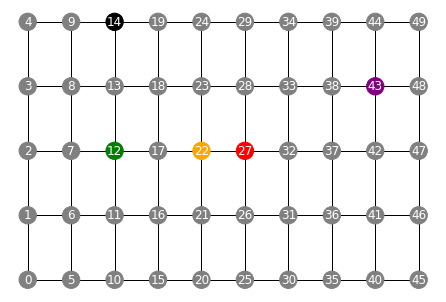

In [94]:
# Initialize an instance of the MatheFireflies class
math_fireflies = MathFireflies(n_rows=10,
                               n_columns=5,
                               start_values={
                                    'orange' : 22,
                                    'purple' : 43,
                                    'red' : 27,
                                    'green' : 12,
                                    'black' : 14
                               })

# Plot the starting graph
math_fireflies.visualize_starting_graph()

#### Aufgabenteil c): Lösung des Problems und Visualisierung (ohne Rechtecksbedingung) 

Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (win64)
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads
Optimize a model with 2360 rows, 2500 columns and 17450 nonzeros
Model fingerprint: 0x9f4daae8
Variable types: 0 continuous, 2500 integer (2500 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [0e+00, 0e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+01]
Presolve removed 191 rows and 201 columns
Presolve time: 0.10s
Presolved: 2169 rows, 2299 columns, 12999 nonzeros
Variable types: 0 continuous, 2299 integer (2299 binary)

Root relaxation: objective 0.000000e+00, 1438 iterations, 0.53 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    0.00000    0  224          -    0.00000      -     -    1s
     0     0    0.00000    0  377          -    0.00000      -     -    2s
H    0     0

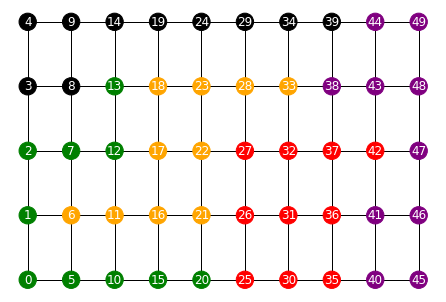

In [95]:
# Initialize an instance of the MatheFireflies class
math_fireflies = MathFireflies(n_rows=10,
                               n_columns=5,
                               start_values={
                                    'orange' : 22,
                                    'purple' : 43,
                                    'red' : 27,
                                    'green' : 12,
                                    'black' : 14
                               })

# Solve the binary optimization problem
m1, r1 = math_fireflies.solve(prevent_rectangles=False)

# Visualize the resulting graph
math_fireflies.visualize_result()

#### Aufgabenteil d): Lösung des Problems und Visualisierung (mit Rechtecksbedingung) 

Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (win64)
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads
Optimize a model with 4860 rows, 2500 columns and 43750 nonzeros
Model fingerprint: 0x8f48ca5c
Variable types: 0 continuous, 2500 integer (2500 binary)
Coefficient statistics:
  Matrix range     [1e+00, 4e+00]
  Objective range  [0e+00, 0e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+01]
Presolve removed 1143 rows and 252 columns
Presolve time: 0.64s
Presolved: 3717 rows, 2248 columns, 34861 nonzeros
Variable types: 0 continuous, 2248 integer (2248 binary)

Root relaxation: objective 0.000000e+00, 1571 iterations, 0.39 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    0.00000    0  294          -    0.00000      -     -    4s
     0     0    0.00000    0  456          -    0.00000      -     -    5s
     0     

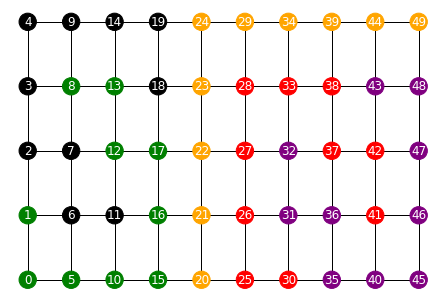

In [96]:
# Initialize an instance of the MatheFireflies class
math_fireflies = MathFireflies(n_rows=10,
                               n_columns=5,
                               start_values={
                                    'orange' : 22,
                                    'purple' : 43,
                                    'red' : 27,
                                    'green' : 12,
                                    'black' : 14
                               })

# Solve the binary optimization problem
m2 = math_fireflies.solve(prevent_rectangles=True)

# Visualize the resulting graph
math_fireflies.visualize_result()